In [2]:
import torch

# 5.自动微分
深度学习框架通过自动计算导数，即自动微分（automatic differentiation）来加快求导。 实际中，根据设计好的模型，系统会构建一个计算图（computational graph）， 来跟踪计算是哪些数据通过哪些操作组合起来产生输出。 自动微分使系统能够随后反向传播梯度。 这里，反向传播（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

## 1.自动求导例子
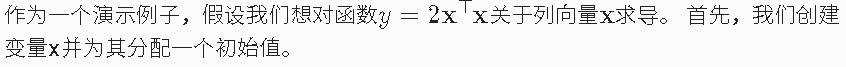

In [3]:
x=torch.arange(4.0)
print(x)

tensor([0., 1., 2., 3.])


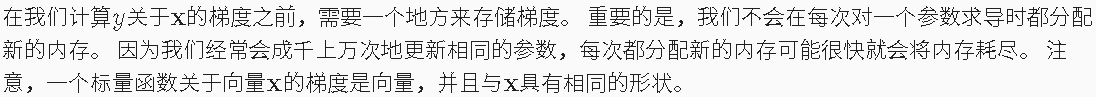

In [5]:
x.requires_grad_(True)
x.grad
#现在计算y
y=2*torch.dot(x,x)
print(y)

tensor(28., grad_fn=<MulBackward0>)


x是一个长度为4的向量，计算x和x的点积，得到了我们赋值给y的标量输出。 接下来，通过调用反向传播函数来自动计算y关于x每个分量的梯度，并打印这些梯度。

In [6]:
y.backward()
print(x.grad)

tensor([ 0.,  4.,  8., 12.])


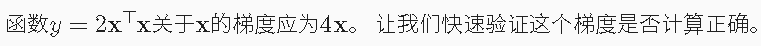

In [7]:
print(x.grad==4*x)

tensor([True, True, True, True])


In [8]:
# 现在计算x的另一个函数。

# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y=x.sum()
y.backward()
print(x.grad)

tensor([1., 1., 1., 1.])


### 1.1 反向传播例子
我来通过一个简单的例子解释反向传播。



让我们用一个最简单的神经网络来说明:
假设我们有一个只有一个隐藏层的神经网络，用来预测房价。

1. 前向传播过程：
```python
输入 x = 100(平方米)
隐藏层权重 w1 = 0.1
隐藏层输出 h = x * w1 = 10
输出层权重 w2 = 0.2
预测输出 y_pred = h * w2 = 2
实际房价 y_true = 3
误差 error = y_true - y_pred = 1
```

2. 反向传播过程：
- 首先计算误差对输出层权重(w2)的梯度：
```python
∂error/∂w2 = ∂(y_true - y_pred)/∂w2 = -h = -10
```

- 然后计算误差对隐藏层权重(w1)的梯度：
```python
∂error/∂w1 = ∂error/∂y_pred * ∂y_pred/∂h * ∂h/∂w1
            = -1 * w2 * x 
            = -1 * 0.2 * 100 
            = -20
```

3. 更新权重：
如果学习率 η = 0.01，则：
```python
w2_new = w2 - η * (∂error/∂w2) = 0.2 - 0.01 * (-10) = 0.3
w1_new = w1 - η * (∂error/∂w1) = 0.1 - 0.01 * (-20) = 0.3
```

这个例子展示了反向传播的核心思想：
1. 从输出层开始，逐层向后计算每个权重对误差的影响（梯度）
2. 使用链式法则传递梯度
3. 根据梯度更新权重，使预测结果越来越接近真实值



## 2.非标量变量的反向传播
当y不是标量时，向量y关于向量x的导数的最自然解释是一个矩阵。 对于高阶和高维的y和x，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括深度学习中）， 但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。 这里，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。

In [10]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y=x*x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
print(x.grad)

tensor([0., 2., 4., 6.])


## 3.分离计算
有时，我们希望将某些计算移动到记录的计算图之外。 例如，假设y是作为x的函数计算的，而z则是作为y和x的函数计算的。 想象一下，我们想计算z关于x的梯度，但由于某种原因，希望将y视为一个常数， 并且只考虑到x在y被计算后发挥的作用。

这里可以分离y来返回一个新变量u，该变量与y具有相同的值， 但丢弃计算图中如何计算y的任何信息。 换句话说，梯度不会向后流经u到x。 因此，下面的反向传播函数计算z=u*x关于x的偏导数，同时将u作为常数处理， 而不是z=x*x*x关于x的偏导数。

In [11]:
x.grad.zero_()
y=x*x
u=y.detach()
z=u*x

z.sum().backward()
print(x.grad==u)

tensor([True, True, True, True])


## 4.Python控制流的梯度计算
使用自动微分的一个好处是： 即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。 在下面的代码中，while循环的迭代次数和if语句的结果都取决于输入a的值。

In [12]:
def f(a):
    b=a*2
    while b.norm()<1000:
        b=b*2
    if b.sum()>0:
        c=b
    else:
        c=100*b
    return c
# 计算梯度
a=torch.randn(size=(),requires_grad=True)
d=f(a)
d.backward()

我们现在可以分析上面定义的f函数。 请注意，它在其输入a中是分段线性的。 换言之，对于任何a，存在某个常量标量k，使得f(a)=k*a，其中k的值取决于输入a，因此可以用d/a验证梯度是否正确。

In [13]:
print(a.grad==d/a)

tensor(True)


## 5.小结
深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。

## 6.练习
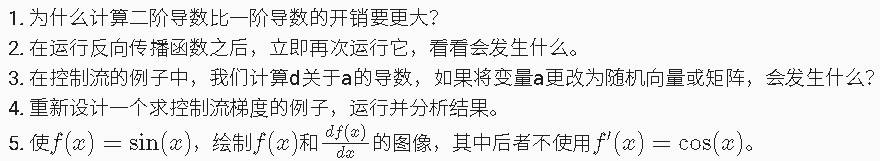

# T1
让我通过一个简单的例子来解释为什么二阶导数的计算开销比一阶导数大。

1. 假设有一个简单的神经网络计算：
```python
x = 2
w1 = 3
w2 = 4
y = w2 * (w1 * x)
```

2. 计算一阶导数：
- dy/dw1 = w2 * x = 4 * 2 = 8
- dy/dw2 = w1 * x = 3 * 2 = 6

只需要进行一次前向传播和一次反向传播。

3. 计算二阶导数：
- d²y/dw1² = 0
- d²y/dw2² = 0
- d²y/dw1dw2 = x = 2

需要：
1. 一次前向传播
2. 一次反向传播得到一阶导数
3. 对每个一阶导数再进行一次反向传播

主要开销大的原因：

1. **计算量增加**
- 一阶导数：需要n次运算（n是参数数量）
- 二阶导数：需要n²次运算
- 对于有百万参数的神经网络，计算量差异巨大

2. **内存占用**
- 一阶导数：存储n个梯度值
- 二阶导数：存储n×n的Hessian矩阵
- 例如：1000万参数的网络
  - 一阶导数：需要约40MB内存(10^7 * 4字节)
  - 二阶导数：需要约400TB内存(10^7 * 10^7 * 4字节)

3. **计算图复杂度**
```python
# 一阶导数的计算图
y = f(x)
dy/dx = f'(x)

# 二阶导数的计算图
y = f(x)
dy/dx = f'(x)
d²y/dx² = f''(x) = (f'(x))'
```
每计算一次导数都需要构建和保存计算图。

4. **优化算法例子**：
```python
# 一阶优化(梯度下降)
w = w - learning_rate * dy/dw

# 二阶优化(牛顿法)
w = w - learning_rate * (dy/dw) / (d²y/dw²)
```

这就是为什么实践中：
1. 大多数深度学习优化算法使用一阶导数（如SGD、Adam）
2. 二阶方法通常使用近似（如L-BFGS）
3. 有些算法（如AdaGrad）用对角Hessian近似来平衡计算效率和优化效果

---

In [20]:
# 2
z=torch.arange(4.0)
z.requires_grad_(True)
# 初始梯度为none
print(z.grad)
f=2*torch.dot(z,z)
print(f)
# 计算第一次梯度
f.backward()
print(z.grad)
# 梯度清零操作
z.grad.zero_()
# 计算第二次梯度
f.backward()
print(z.grad)


None
tensor(28., grad_fn=<MulBackward0>)
tensor([ 0.,  4.,  8., 12.])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

报错详解：
这个错误是因为PyTorch在执行第一次backward()后默认会释放计算图以节省内存。让我详细解释：

1. 首先看代码执行过程：
```python
z = torch.arange(4.0)
z.requires_grad_(True)
# z = [0.0, 1.0, 2.0, 3.0]

print(z.grad)  # None，初始没有梯度

f = 2 * torch.dot(z,z)
# f = 2 * (0² + 1² + 2² + 3²) = 2 * 14 = 28

# 第一次反向传播
f.backward()
print(z.grad)  # tensor([0., 4., 8., 12.])

# 第二次反向传播
f.backward()  # 报错！
```

2. 为什么会报错？
- PyTorch为了节省内存，默认在执行backward()后会释放计算图
- 计算图包含了从输入到输出的所有中间计算步骤
- 释放后就无法进行第二次反向传播

3. 如何解决？
添加retain_graph=True：
```python
z = torch.arange(4.0)
z.requires_grad_(True)

f = 2 * torch.dot(z,z)

# 第一次反向传播
f.backward(retain_graph=True)  # 保留计算图
print(z.grad)  # tensor([0., 4., 8., 12.])

# 第二次反向传播
f.backward()
print(z.grad)  # tensor([0., 8., 16., 24.]) # 梯度会累加！
```

4. 注意事项：
- 梯度会累加！如果需要重新计算梯度，应该先清零：
```python
z = torch.arange(4.0)
z.requires_grad_(True)

f = 2 * torch.dot(z,z)

# 第一次反向传播
f.backward(retain_graph=True)
print(z.grad)  # tensor([0., 4., 8., 12.])

# 清零梯度
z.grad.zero_()

# 第二次反向传播
f.backward()
print(z.grad)  # tensor([0., 4., 8., 12.])
```

5. 实际应用中：
```python
# 典型的训练循环
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    # 前向传播
    output = model(input)
    loss = criterion(output, target)
    
    # 清零梯度
    optimizer.zero_grad()
    
    # 反向传播
    loss.backward()
    
    # 更新参数
    optimizer.step()
```

retain_graph=True主要用于：
1. 需要多次计算同一个计算图的梯度
2. 需要计算高阶导数
3. 在RNN这样的循环网络中复用计算图

但要注意：
- 保留计算图会占用更多内存
- 如果不需要多次反向传播，最好不要使用retain_graph=True
- 在实际训练中，每次反向传播前记得清零梯度


---

In [46]:
#3 默认情况下会报错,标量只能对标量求导
def f(a):
    b=a*2
#     while b.norm()<1000:
#         b=b*2
    if b.sum()>0:
        c=b*3
    else:
        c=100*b
    return c

# 计算梯度
# a=torch.randn(size=(),requires_grad=True)
# a=torch.arange(9,dtype=torch.float32,requires_grad=True)
a=torch.arange(9,dtype=torch.float32,requires_grad=True).reshape(3,3)
print(a)

# 前向传播
d=f(a)
print(d)

# 反向传播
# d.backward() #报错，如果是标量就可以
d.backward(torch.ones_like(d))#需要指定梯度形状
print(a.grad)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]], grad_fn=<ReshapeAliasBackward0>)
tensor([[ 0.,  6., 12.],
        [18., 24., 30.],
        [36., 42., 48.]], grad_fn=<MulBackward0>)
None


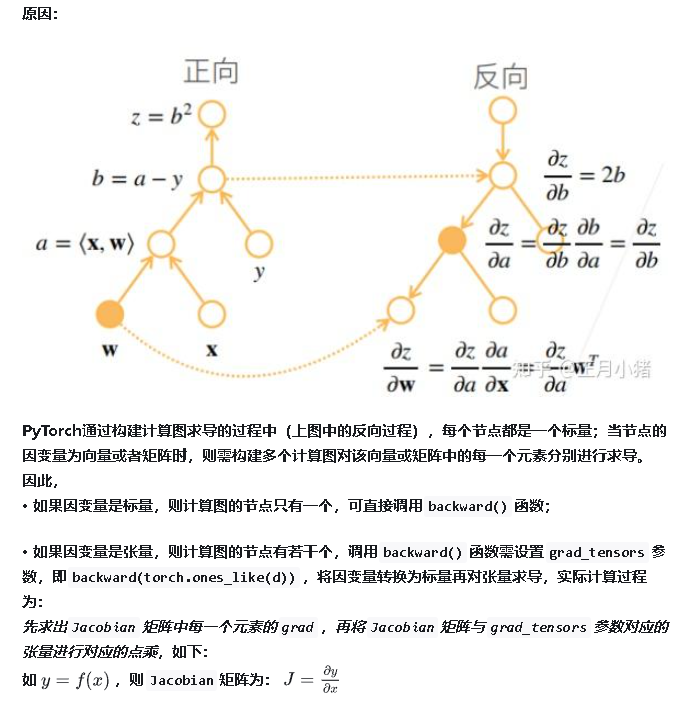

---

tensor([-0.8391, -0.8892, -0.9304, -0.9624, -0.9847, -0.9972, -0.9997, -0.9922,
        -0.9748, -0.9477, -0.9111, -0.8654, -0.8111, -0.7486, -0.6787, -0.6020,
        -0.5193, -0.4314, -0.3392, -0.2435, -0.1455, -0.0460,  0.0540,  0.1534,
         0.2513,  0.3466,  0.4385,  0.5261,  0.6084,  0.6845,  0.7539,  0.8157,
         0.8694,  0.9144,  0.9502,  0.9766,  0.9932,  0.9999,  0.9965,  0.9833,
         0.9602,  0.9275,  0.8855,  0.8347,  0.7756,  0.7087,  0.6347,  0.5544,
         0.4685,  0.3780,  0.2837,  0.1865,  0.0875, -0.0124, -0.1122, -0.2108,
        -0.3073, -0.4008, -0.4903, -0.5748, -0.6536, -0.7259, -0.7910, -0.8481,
        -0.8968, -0.9365, -0.9668, -0.9875, -0.9983, -0.9991, -0.9900, -0.9710,
        -0.9422, -0.9041, -0.8569, -0.8011, -0.7374, -0.6663, -0.5885, -0.5048,
        -0.4161, -0.3233, -0.2272, -0.1288, -0.0292,  0.0707,  0.1700,  0.2675,
         0.3624,  0.4536,  0.5403,  0.6216,  0.6967,  0.7648,  0.8253,  0.8776,
         0.9211,  0.9553,  0.9801,  0.99

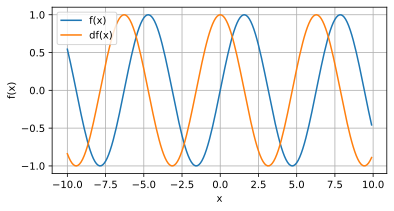

In [49]:
#4
import torch
import numpy as np
from matplotlib_inline import backend_inline
from d2l import torch as d2l

def use_svg_display(): 
    backend_inline.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)): 
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim) 
    axes.set_ylim(ylim) 
    if legend:
        axes.legend(legend)
    axes.grid()
    
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear', figsize=(6, 3), axes=None):
    
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()
   
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    
    for x, y in zip(X, Y):
        if len(x):
            axes.plot(x, y)
        else:
            axes.plot(y)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
x=torch.arange(-10,10,0.1,requires_grad=True)
y=torch.sin(x)
y.backward(torch.ones_like(y))
d=x.grad
print(d)
draw_x=x.detach().numpy()#需要detach一下,否则会报错
draw_y=y.detach().numpy()
draw_d=d.numpy()
plot(draw_x,[draw_y,draw_d],'x','f(x)',legend=['f(x)','df(x)'])
